# Customer Segmentation Theory

# analysis

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_excel("Online Retail.xlsx")
df.head(5)

In [ ]:
df.info()

In [ ]:
df.describe()

In [19]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [18]:
df.dropna(subset = ["CustomerID"], inplace = True)

In [32]:
# Removing Cancelled and Returned orders from the dataset

df = df[(df["Quantity"] > 0) & (~df["InvoiceDate"].astype(str).str.contains("C"))]

In [35]:
# Creating and new column or feature names TotalPrice
df["TotalPrice"] = df["UnitPrice"] * df["Quantity"]

In [37]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [43]:
# converting invoice date into datatime format
df["InvoiceDate"]= pd.to_datetime(df["InvoiceDate"], errors = 'coerce')

In [54]:
current_date = df["InvoiceDate"].max() + pd.Timedelta(days = 1)
current_date

Timestamp('2011-12-10 12:50:00')

In [20]:
rfm = df.groupby("CustomerID").agg(
    Recency=('InvoiceDate', lambda date: (current_date - date.max()).days),
    Frequency=('InvoiceNo', 'nunique'),
    # nunique counts the unique values
    Monetary=('TotalPrice', 'sum'))

In [21]:
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [25]:
rfm= rfm[rfm["Monetary"]> 0]

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [27]:
rfm_log =rfm.copy()

In [28]:
rfm_log

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,2,7,4310.00
12348.0,75,4,1797.24
12349.0,19,1,1757.55
12350.0,310,1,334.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [29]:
rfm_log["Recency_log"] = rfm_log["Recency"].apply(lambda x : np.log(x) if x>0 else np.log(1))
rfm_log["Frequency_log"] = rfm_log["Frequency"].apply(lambda x: np.log(x))
rfm_log["Monetary_log"] = rfm_log["Monetary"].apply(lambda x: np.log(x))

In [31]:
rfm_log = rfm_log[["Recency_log", "Frequency_log", "Monetary_log"]]

In [33]:
rfm_log

,Recency_log,Frequency_log,Monetary_log
CustomerID,,,
12346.0,5.786897,0.000000,11.253942
12347.0,0.693147,1.945910,8.368693
12348.0,4.317488,1.386294,7.494007
12349.0,2.944439,0.000000,7.471676
12350.0,5.736572,0.000000,5.812338
...,...,...,...
18280.0,5.627621,0.000000,5.196285
18281.0,5.198497,0.000000,4.392224
18282.0,2.079442,0.693147,5.182064


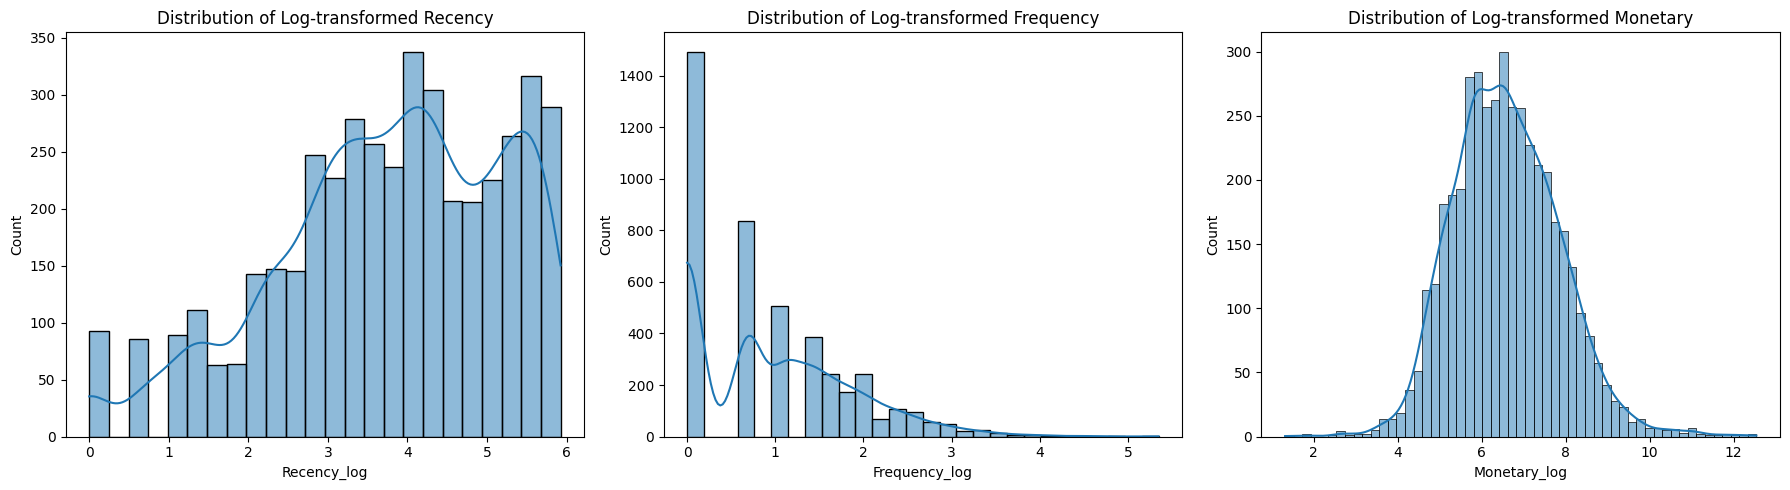

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5)) # Why: Create a figure and 3 subplots for easy comparison.
sns.histplot(rfm_log['Recency_log'], kde=True, ax=axes[0])
axes[0].set_title('Distribution of Log-transformed Recency')
sns.histplot(rfm_log['Frequency_log'], kde=True, ax=axes[1])
axes[1].set_title('Distribution of Log-transformed Frequency')
sns.histplot(rfm_log['Monetary_log'], kde=True, ax=axes[2])
axes[2].set_title('Distribution of Log-transformed Monetary')
plt.tight_layout() # Why: Adjusts subplot parameters for a tight layout, preventing labels from overlapping.
plt.savefig("Distribution_chart", dpi=300, bbox_inches='tight')  # Saves the plot to a file
plt.show()

In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [37]:
scaler = StandardScaler()

In [40]:
rfm_scaled = scaler.fit_transform(rfm_log)

In [41]:
rfm_scaled

array([[ 1.40989446, -1.04861563,  3.69871931],
       [-2.14649825,  1.11171381,  1.410201  ],
       [ 0.38397128,  0.49043411,  0.71641884],
       ...,
       [-1.17860486, -0.27909076, -1.11736527],
       [-1.66255156,  2.02948385,  0.83796882],
       [-0.00442205,  0.17105244,  0.73389579]])

In [42]:
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=rfm_log.columns, index=rfm_log.index)

In [43]:
rfm_scaled_df

,Recency_log,Frequency_log,Monetary_log
CustomerID,,,
12346.0,1.409894,-1.048616,3.698719
12347.0,-2.146498,1.111714,1.410201
12348.0,0.383971,0.490434,0.716419
12349.0,-0.574674,-1.048616,0.698706
12350.0,1.374758,-1.048616,-0.617446
...,...,...,...
18280.0,1.298690,-1.048616,-1.106086
18281.0,0.999081,-1.048616,-1.743850
18282.0,-1.178605,-0.279091,-1.117365


In [44]:
print(rfm_scaled_df.describe())

        Recency_log  Frequency_log  Monetary_log
count  4.338000e+03    4338.000000  4.338000e+03
mean  -1.048288e-16       0.000000 -7.010426e-16
std    1.000115e+00       1.000115  1.000115e+00
min   -2.630445e+00      -1.048616 -4.179280e+00
25%   -6.124235e-01      -1.048616 -6.841832e-01
50%    1.147066e-01      -0.279091 -6.094235e-02
75%    8.296516e-01       0.738166  6.542440e-01
max    1.505796e+00       4.887688  4.721395e+00


In [50]:
wcss = [] # Why: List to store WCSS values for each K.
silhouette_scores = [] # Why: List to store Silhouette Scores for each K.
k_range = range(2, 11) # Why: It's common to test K from 2 upwards. 1 cluster is trivial.

for k in k_range:
    # How: Initialize KMeans.
    #      n_clusters=k: Specify the current number of clusters.
    #      random_state=42: Ensures reproducibility. If you run the code multiple times,
    #                       the random initialization of centroids will be the same.
    #      n_init=10: (Important for newer scikit-learn versions) Specifies the number of times
    #                 the K-Means algorithm will be run with different centroid seeds.
    #                 The final model will be the one with the best WCSS.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10) # n_init for modern scikit-learn
    kmeans.fit(rfm_scaled_df) # How: Train the KMeans model on the scaled data.

    wcss.append(kmeans.inertia_) # How: .inertia_ attribute gives the WCSS after fitting.

    # How: Calculate Silhouette Score.
    #      silhouette_score(X, labels) takes the data (X) and the cluster labels (labels)
    #      returned by the fitted KMeans model (.labels_).
    score = silhouette_score(rfm_scaled_df, kmeans.labels_)
    silhouette_scores.append(score)

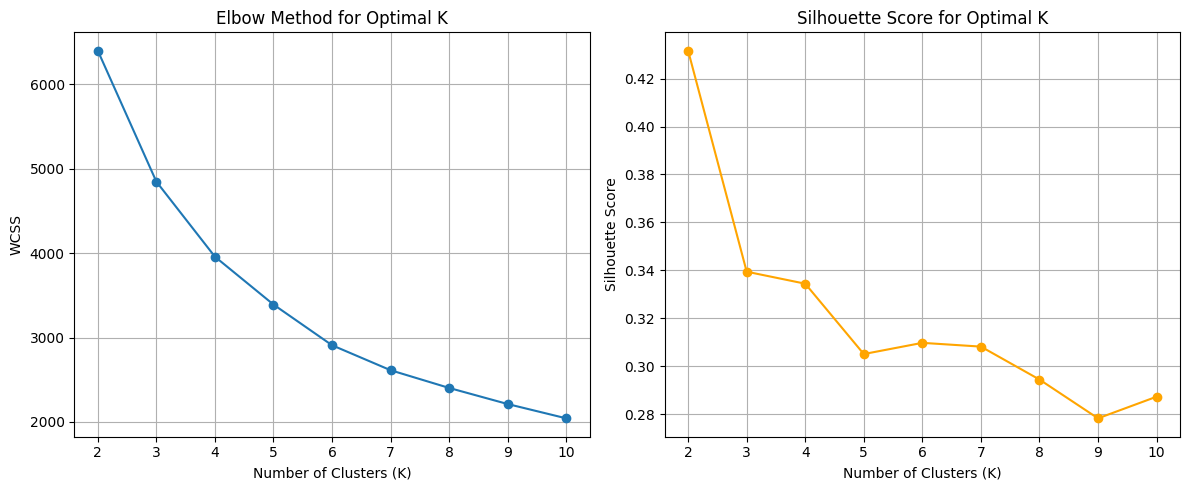


Silhouette Scores for K ranging from 2 to 10:
K=2: 0.4316
K=3: 0.3394
K=4: 0.3344
K=5: 0.3051
K=6: 0.3098
K=7: 0.3082
K=8: 0.2944
K=9: 0.2783
K=10: 0.2873


In [57]:
# Why: Visualize WCSS and Silhouette Score to help choose K.
plt.figure(figsize=(12, 5))

# How: Plot WCSS vs K (Elbow Method).
plt.subplot(1, 2, 1) # Why: Create a 1 row, 2 column plot grid, select the 1st subplot.
plt.plot(k_range, wcss, marker='o') # How: Plot points with circles.
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.xticks(k_range) # Why: Ensure K values on x-axis are clearly marked.
plt.grid(True) # Why: Add a grid for easier reading.

# How: Plot Silhouette Score vs K.
plt.subplot(1, 2, 2) # Why: Select the 2nd subplot.
plt.plot(k_range, silhouette_scores, marker='o', color='orange')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.xticks(k_range)
plt.grid(True)
plt.tight_layout() # Why: Prevents plots/titles from overlapping.
plt.savefig("Elbow_method_chart", dpi=300, bbox_inches='tight')
plt.show()

print("\nSilhouette Scores for K ranging from 2 to 10:")
for k, score in zip(k_range, silhouette_scores): # Why: Iterate and print scores nicely.
    print(f"K={k}: {score:.4f}") # Why: f-string for formatted output.

In [52]:
# Why: Based on our analysis from the elbow method and silhouette score,
#      we choose K=4. You would explain *your* reasoning in your portfolio.
optimal_k = 4

# How: Initialize KMeans with the chosen optimal_k.
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(rfm_scaled_df) # How: Train the model on the scaled data.

# Why: The .labels_ attribute of the fitted KMeans model contains the cluster ID for each data point.
#      We add these labels back to our original (non-scaled, non-log-transformed) RFM DataFrame.
#      This allows us to easily associate the cluster ID with the actual Recency, Frequency, and Monetary values.
rfm['Cluster'] = kmeans.labels_

print(f"\nNumber of customers per cluster (for K={optimal_k}):")
# Why: .value_counts() tells you how many customers are in each cluster.
#      This helps understand the size of each segment.
print(rfm['Cluster'].value_counts())
print("\nFirst 5 rows of RFM with Cluster labels:")
print(rfm.head())

C:\Users\kapil\AppData\Local\Temp\ipykernel_7044\3447282003.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['Cluster'] = kmeans.labels_



Number of customers per cluster (for K=4):
Cluster
3    1574
2    1255
0     759
1     750
Name: count, dtype: int64

First 5 rows of RFM with Cluster labels:
            Recency  Frequency  Monetary  Cluster
CustomerID                                       
12346.0         326          1  77183.60        2
12347.0           2          7   4310.00        1
12348.0          75          4   1797.24        2
12349.0          19          1   1757.55        0
12350.0         310          1    334.40        3



Average RFM values for each cluster (these are the 'personas'):
         Recency_mean  Frequency_mean  Monetary_mean
Cluster                                             
0               18.74            1.99         502.81
1               10.60           13.13        7748.79
2               72.64            4.12        1736.53
3              183.03            1.27         342.33


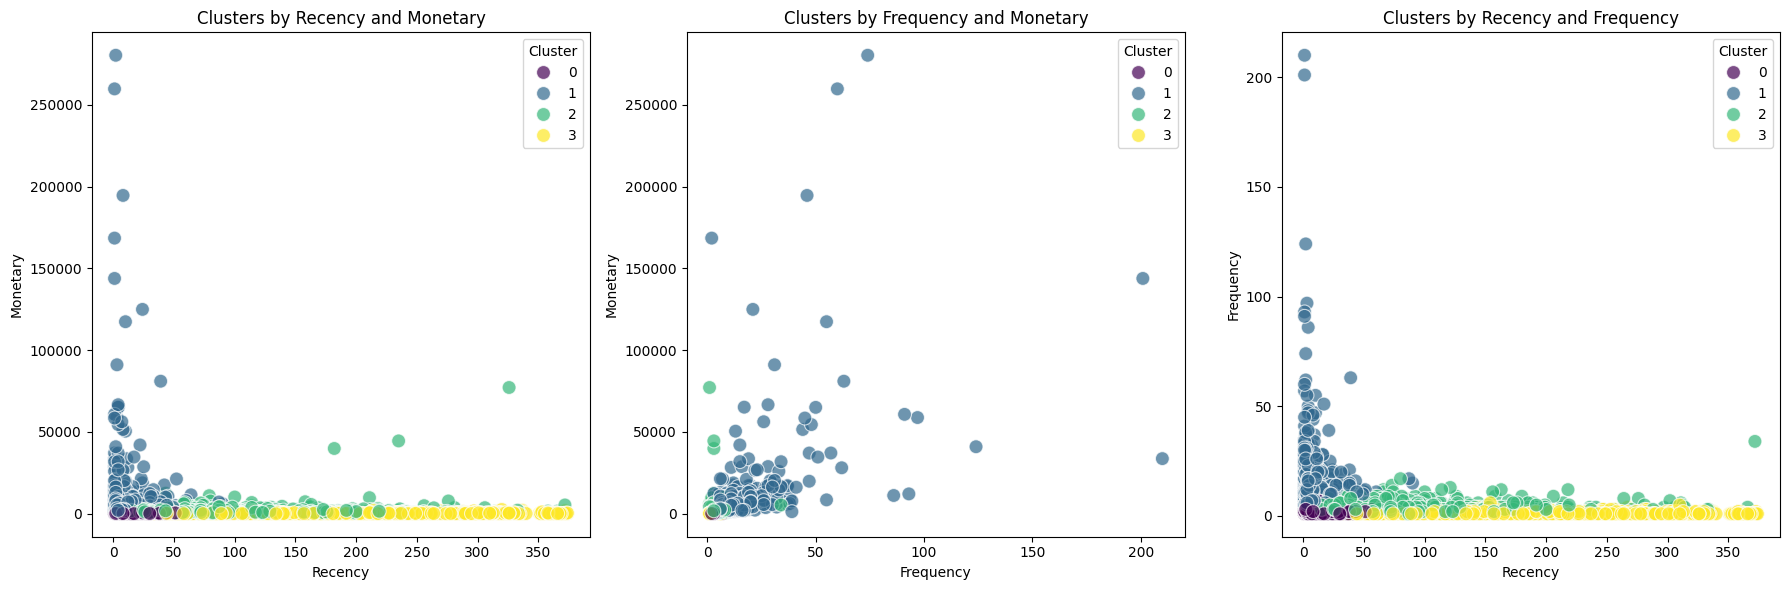

C:\Users\kapil\AppData\Local\Temp\ipykernel_7044\3919001041.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='viridis')
C:\Users\kapil\AppData\Local\Temp\ipykernel_7044\3919001041.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='viridis')
C:\Users\kapil\AppData\Local\Temp\ipykernel_7044\3919001041.py:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='viridis')


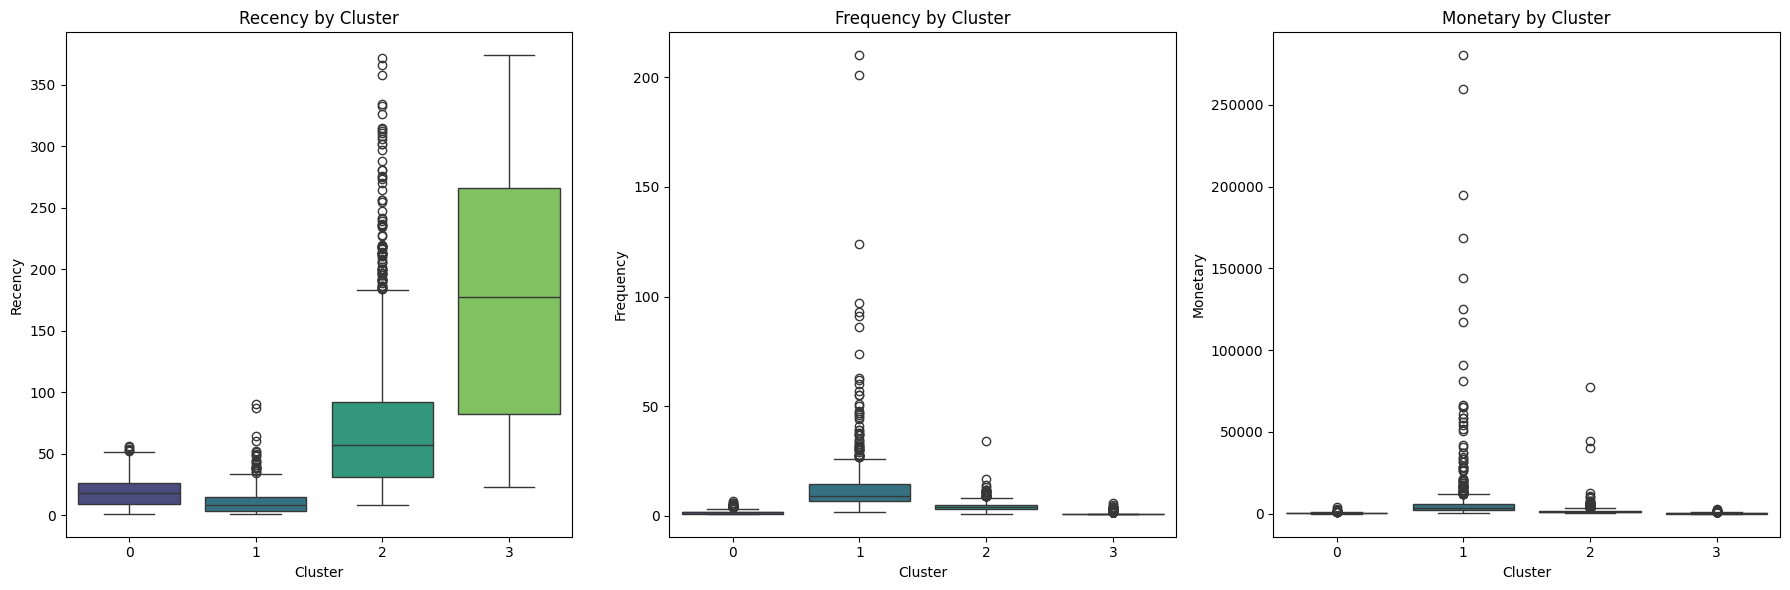

In [59]:
# Why: To understand the typical customer in each cluster, we calculate the mean (average)
#      Recency, Frequency, and Monetary values for each cluster.
# How: .groupby('Cluster') groups the data by the assigned cluster ID.
#      .agg() calculates the mean for each RFM column within each group.
#      .round(2) rounds the results for cleaner output.
cluster_centers = rfm.groupby('Cluster').agg(
    Recency_mean=('Recency', 'mean'),
    Frequency_mean=('Frequency', 'mean'),
    Monetary_mean=('Monetary', 'mean')
).round(2)

print("\nAverage RFM values for each cluster (these are the 'personas'):")
print(cluster_centers)

# Why: Visualizations help in interpreting clusters beyond just numbers.
#      Scatter plots show relationships between two RFM features, colored by cluster.
#      Box plots show the distribution (median, quartiles, outliers) of each RFM feature
#      across different clusters, making differences clearer.

# How: Create a figure with 3 subplots for scatter plots.
plt.figure(figsize=(18, 6)) # Why: Larger figure for better visibility.

plt.subplot(1, 3, 1)
# How: sns.scatterplot() creates a scatter plot.
#      x='Recency', y='Monetary': Features to plot.
#      hue='Cluster': Color points based on their cluster ID. This is key for visualization.
#      data=rfm: Use the DataFrame containing the RFM values and cluster IDs.
#      palette='viridis': Choose a color scheme.
#      s=100: Set marker size.
#      alpha=0.7: Set transparency for better visibility in dense areas.
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters by Recency and Monetary')

plt.subplot(1, 3, 2)
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters by Frequency and Monetary')

plt.subplot(1, 3, 3)
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm, palette='viridis', s=100, alpha=0.7)
plt.title('Clusters by Recency and Frequency')

plt.tight_layout()
plt.savefig("cluster_chart", dpi=300, bbox_inches='tight')
plt.show()

# How: Create another figure with 3 subplots for box plots.
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
# How: sns.boxplot() creates a box plot.
#      x='Cluster': Group data by cluster on the x-axis.
#      y='Recency': The feature whose distribution we want to see.
sns.boxplot(x='Cluster', y='Recency', data=rfm, palette='viridis')
plt.title('Recency by Cluster')

plt.subplot(1, 3, 2)
sns.boxplot(x='Cluster', y='Frequency', data=rfm, palette='viridis')
plt.title('Frequency by Cluster')

plt.subplot(1, 3, 3)
sns.boxplot(x='Cluster', y='Monetary', data=rfm, palette='viridis')
plt.title('Monetary by Cluster')

plt.tight_layout()
plt.savefig("Cluster_Box_Plot", dpi=300, bbox_inches='tight')
plt.show()